In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
from typing import Dict, List, Mapping, Optional

class EmbedderBlock(eqx.Module):
    """
    Embeds input data from daily and irregular time series along with position indices.
    Includes dropout on the embeddings.
    """
    data_embedder: eqx.nn.Linear
    position_embedder: eqx.nn.Embedding
    layernorm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout

    def __init__(self, 
                 dynamic_in_size: int, 
                 max_length: int, 
                 hidden_size: int,
                 dropout_rate: float, 
                 key: jax.random.PRNGKey):
        
        self.data_embedder = eqx.nn.Linear(in_features=dynamic_in_size, out_features=hidden_size, key=key)
        self.position_embedder = eqx.nn.Embedding(num_embeddings=max_length, embedding_size=hidden_size, key=key)
        self.layernorm = eqx.nn.LayerNorm(shape=(2*hidden_size,))
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(self, 
                 dynamic_data: jnp.ndarray, 
                 position_ids: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray:  
        
        data_embeds = jax.vmap(self.data_embedder)(dynamic_data)
        position_embeds = jax.vmap(self.position_embedder)(position_ids)
        
        # embedded_inputs = daily_embeds + irregular_embeds + position_embeds
        embedded_inputs = jnp.concatenate([data_embeds, position_embeds], axis=-1)
        embedded_inputs = self.dropout(embedded_inputs, key=key)
        embedded_inputs = jax.vmap(self.layernorm)(embedded_inputs)
        return embedded_inputs


class AttentionBlock(eqx.Module):
    """
    Implements a multi-head self-attention mechanism, integrating static data into the attention process.
    Includes dropout in the output of the attention.
    """
    attention: eqx.nn.MultiheadAttention
    layernorm: eqx.nn.LayerNorm
    static_linear: eqx.nn.Linear
    dropout: eqx.nn.Dropout

    def __init__(self, 
                 hidden_size: int, 
                 num_heads: int, 
                 static_in_size: int,
                 dropout_rate: float,
                 key: jax.random.PRNGKey): 
        keys = jax.random.split(key)
        
        self.attention = eqx.nn.MultiheadAttention(
            num_heads=num_heads, 
            query_size=hidden_size, 
            key_size=hidden_size, 
            value_size=hidden_size, 
            output_size=hidden_size, 
            key=keys[0])
        self.layernorm = eqx.nn.LayerNorm(shape=(hidden_size,))
        self.static_linear = eqx.nn.Linear(in_features=static_in_size, out_features=hidden_size, key=keys[1])
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(self, 
                 inputs: jnp.ndarray, 
                 static_data: jnp.ndarray,
                 base_mask: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray:
        static_embedding = self.static_linear(static_data)
        static_embedding = jnp.expand_dims(static_embedding, axis=0)
        modified_keys = inputs + static_embedding
        modified_values = inputs + static_embedding

        irregular_mask = jnp.tile(base_mask, (inputs.shape[0], 1))
        daily_mask = jnp.ones_like(irregular_mask)
        multihead_mask = jnp.stack([irregular_mask, daily_mask], axis=0)
        
        attention_output = self.attention(inputs, modified_keys, modified_values, multihead_mask)
        attention_output = self.dropout(attention_output, key=key)
        result = attention_output + inputs
        result = jax.vmap(self.layernorm)(result)
        return result

class FeedForwardBlock(eqx.Module):
    """
    Applies a two-layer feed-forward network with GELU activation in between. Includes dropout after the MLP layer.
    """
    mlp: eqx.nn.Linear
    output: eqx.nn.Linear
    layernorm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout

    def __init__(self, 
                 hidden_size: int, 
                 intermediate_size: int,
                 dropout_rate: float,
                 key: jax.random.PRNGKey): 
        keys = jax.random.split(key)
        
        self.mlp = eqx.nn.Linear(in_features=hidden_size, out_features=intermediate_size, key=keys[0])
        self.output = eqx.nn.Linear(in_features=intermediate_size, out_features=hidden_size, key=keys[1])
        self.layernorm = eqx.nn.LayerNorm(shape=(hidden_size,))
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(self,
                 inputs: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray: 
        hidden = self.mlp(inputs)
        hidden = jax.nn.gelu(hidden)
        hidden = self.dropout(hidden, key=key)
        output = self.output(hidden)
        output += inputs
        output = self.layernorm(output) 
        return output

class TransformerLayer(eqx.Module):
    attention_block: AttentionBlock
    ff_block: FeedForwardBlock

    def __init__(self, 
                 hidden_size: int, 
                 intermediate_size: int, 
                 num_heads: int, 
                 static_in_size: int, 
                 dropout_p: float,
                 key: jax.random.PRNGKey):
        keys = jax.random.split(key)
        
        self.attention_block = AttentionBlock(hidden_size, num_heads, static_in_size, dropout_p, keys[0])
        self.ff_block = FeedForwardBlock(hidden_size, intermediate_size, dropout_p, keys[1])

    def __call__(self, 
                 inputs: jnp.ndarray, 
                 static_data: jnp.ndarray,
                 mask: jnp.ndarray,
                 key: jax.random.PRNGKey) -> jnp.ndarray:
        keys = jax.random.split(key)
        
        attention_output = self.attention_block(inputs, static_data, mask, keys[0])
        
        ff_keys = jax.random.split(keys[1], attention_output.shape[0])
        output = jax.vmap(self.ff_block)(attention_output, ff_keys)
        return output

class Encoder(eqx.Module):
    embedder_block: EmbedderBlock
    layers: List[TransformerLayer]
    pooler: eqx.nn.Linear

    def __init__(self, 
                 dynamic_in_size: int, 
                 static_in_size: int, 
                 max_length: int, 
                 hidden_size: int, 
                 intermediate_size: int, 
                 num_layers: int, 
                 num_heads: int, 
                 dropout_p: float,
                 key: jax.random.PRNGKey): 
        keys = jax.random.split(key, num=3)
        
        self.embedder_block = EmbedderBlock(dynamic_in_size, max_length, hidden_size, dropout_p, keys[0])
        layer_keys = jax.random.split(keys[1], num=num_layers)
        self.layers = [TransformerLayer(2*hidden_size, intermediate_size, num_heads, static_in_size, dropout_p, layer_key) for layer_key in layer_keys]
        self.pooler = eqx.nn.Linear(in_features=2*hidden_size, out_features=hidden_size, key=keys[2])

    def __call__(self, 
                 data: dict, 
                 position_ids: jnp.ndarray, 
                 key: jax.random.PRNGKey) -> jnp.ndarray:
        keys = jax.random.split(key)
        
        embeddings = self.embedder_block(data['x_d'], position_ids, keys[0])

        x = embeddings
        layer_keys = jax.random.split(keys[1], len(self.layers))
        for layer, layer_key in zip(self.layers, layer_keys):
            x = layer(x, data['x_s'], data['mask'], layer_key)
        first_token_last_layer = x[..., 0, :]
        pooled = self.pooler(first_token_last_layer)
        pooled = jnp.tanh(pooled)
        return pooled

class EATransformer(eqx.Module):
    encoder: Encoder
    head: eqx.nn.Linear

    def __init__(self, 
                 dynamic_in_size: int, 
                 static_in_size: int, 
                 max_length: int, 
                 hidden_size: int, 
                 intermediate_size: int, 
                 num_layers: int, 
                 num_heads: int, 
                 out_size: int,
                 dropout_p: float, 
                 seed: int):
        key = jax.random.PRNGKey(seed)
        keys = jax.random.split(key)
        
        self.encoder = Encoder(dynamic_in_size=dynamic_in_size,
                               static_in_size=static_in_size,
                               max_length=max_length,
                               hidden_size=hidden_size,
                               intermediate_size=intermediate_size,
                               num_layers=num_layers,
                               num_heads=num_heads,
                               dropout_p=dropout_p,
                               key=keys[0])
        self.head = eqx.nn.Linear(in_features=hidden_size, out_features=out_size, key=keys[1])

    def __call__(self, data: dict, key: jax.random.PRNGKey) -> jnp.ndarray:
        # Kluge to get it running now. Will address data loader later.
        position_ids = jnp.arange(data['x_d'].shape[0]).astype(jnp.int32)

        # for key, value in data.items():
        #     print(f"{key}: {value.shape}")
        # Kluge to get it running now. Will address data loader later.
        
        pooled_output = self.encoder(data, position_ids, key)
        return self.head(pooled_output)

# Configuration
daily_size = 1
irregular_size = 6
static_in_size = 31
num_samples = 10000
sequence_length = 30
p_missing_data = 0.3

config = {
    "dynamic_in_size": daily_size + irregular_size,
    "static_in_size": static_in_size,          
    "max_length": 30, 
    "hidden_size": 256,
    "intermediate_size": 1024,
    "num_layers": 8,
    "num_heads": 2,
    "out_size": 1,
    "dropout_p": 0.4,
    "seed": 0
}
model = EATransformer(**config)

In [ ]:
import numpy as np

params = eqx.filter(model, eqx.is_inexact_array)
leaves = jax.tree_util.tree_leaves(params)
n_params = np.sum([l.size for l in leaves])

def human_readable_size(size_bytes):
    for unit in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size_bytes < 1024:
            return f"{size_bytes:.2f} {unit}"
        size_bytes /= 1024

print(human_readable_size(n_params*4))

In [ ]:
# Generate synthetic data
np.random.seed(42)
daily_data = np.random.rand(num_samples, daily_size).astype(np.float32)
irregular_data = np.random.rand(num_samples, irregular_size).astype(np.float32)
static_data = np.random.rand(num_samples, static_in_size).astype(np.float32)
targets = (
    0.5 * np.sum(daily_data, axis=1) +
    0.3 * np.sum(irregular_data, axis=1) +
    0.2 * np.sum(static_data, axis=1)# +
    # np.random.normal(0, 0.01, num_samples)  # Add some noise
).reshape(num_samples, 1).astype(np.float32)

# Now delete some data from irregular
valid_mask = np.random.rand(num_samples) > p_missing_data   
irregular_data[~valid_mask,:] = 0

# Convert to JAX arrays
daily_data = jnp.array(daily_data)
irregular_data = jnp.array(irregular_data)
static_data = jnp.array(static_data)
targets = jnp.array(targets)

print("Hydrology data shape:", daily_data.shape)
print("Satellite data shape:", irregular_data.shape)
print("Static data shape:", static_data.shape)
print("Targets shape:", targets.shape)

In [ ]:
import optax
import tqdm

# Define loss function
def mse_loss(predictions, targets):
    return jnp.mean((predictions - targets) ** 2)

# Define training step
@eqx.filter_value_and_grad
def compute_loss(model, batch, batch_keys):
    predictions = jax.vmap(model)(batch, batch_keys)
    return mse_loss(predictions, batch['y'])

@eqx.filter_jit
def train_step(model, opt_state, batch, batch_keys):
    loss, grads = compute_loss(model, batch, batch_keys)
    updates, opt_state = tx.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# Training parameters
batch_size = 10
num_batches = num_samples // batch_size
learning_rate = 1e-3
epochs = 25

# Create an optimizer
tx = optax.adam(learning_rate)
opt_state = tx.init(model)

key = jax.random.PRNGKey(0)
loss_list = []
for epoch in range(epochs):
    sample_perm = np.random.permutation(range(sequence_length, num_samples))
    # Check if the number of elements matches num_batches * batch_size
    assert len(sample_perm)%batch_size == 0, "Number of samples must evenly divide into batch size"
    batched_samples = sample_perm.reshape((-1, batch_size))

    epoch_loss = 0.0
    pbar = tqdm.tqdm(batched_samples,desc=f"Epoch {epoch+1}")
    for i, sample_ids in enumerate(pbar):
        batch_ids = []
        for sample_id in sample_ids:
            seq_start = sample_id - sequence_length
            seq_end = sample_id
            batch_ids.append((seq_start, seq_end))
        batch_ids = jnp.array([np.arange(seq_start, seq_end) for seq_start, seq_end in batch_ids])
            
        x_d = jnp.concat([daily_data[batch_ids], irregular_data[batch_ids]], axis=-1)
        batch = {"x_d": x_d,
                 "mask": valid_mask[batch_ids],
                 "x_s": static_data[batch_ids[:,0]],
                 "y": targets[batch_ids[:,-1]]}
        keys = jax.random.split(key, batch_size+1)
        key = keys[0]
        batch_keys = keys[1:]

        model, opt_state, loss = train_step(model, opt_state, batch, batch_keys)
        epoch_loss += loss
        avg_loss = epoch_loss / (i+1)
        pbar.set_postfix_str(f"Loss: {avg_loss:.4f}")
    loss_list.append(avg_loss)


In [ ]:
base_mask = batch['mask'][0]

irregular_mask = jnp.tile(base_mask, (sequence_length, 1))
daily_mask = jnp.ones_like(irregular_mask)

multihead_mask = jnp.stack([irregular_mask, daily_mask], axis=0)

plt.imshow(multihead_mask[1], aspect='auto')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_list)

In [90]:
import math
import jax
import jax.numpy as jnp
import equinox as eqx
from functools import partial
from typing import cast, Optional, Union
from jaxtyping import Array, Bool, Float, PRNGKeyArray

def biased_dot_product_attention_weights(
    query: Float[Array, "q_seq qk_size"],
    key: Float[Array, "kv_seq qk_size"],
    bias: Float[Array, "q_seq kv_seq"], 
    mask: Optional[Bool[Array, "q_seq kv_seq"]] = None) -> Float[Array, "q_seq kv_seq"]:
    
    query = query / math.sqrt(query.shape[-1])
    logits = jnp.einsum("sd,Sd->sS", query, key) + bias

    if mask is not None:
        if mask.shape != logits.shape:
            raise ValueError(
                f"mask must have shape (query_seq_length, "
                f"kv_seq_length)=({query.shape[0]}, "
                f"{key.shape[0]}). Got {mask.shape}."
            )
        logits = jnp.where(mask, logits, jnp.finfo(logits.dtype).min)
        logits = cast(Array, logits)

    with jax.numpy_dtype_promotion("standard"):
        dtype = jnp.result_type(logits.dtype, jnp.float32)
    weights = jax.nn.softmax(logits.astype(dtype)).astype(logits.dtype)
    return weights

def dot_product_attention(
    query: Float[Array, "q_seq qk_size"],
    key_: Float[Array, "kv_seq qk_size"],
    value: Float[Array, "kv_seq v_size"],
    bias: Float[Array, "q_seq kv_seq"], 
    mask: Optional[Bool[Array, "q_seq kv_seq"]] = None,
    dropout: Optional[eqx.nn.Dropout] = None,
    *,
    key: Optional[PRNGKeyArray] = None,
    inference: Optional[bool] = None) -> Float[Array, "q_seq v_size"]:
    
    weights = biased_dot_product_attention_weights(query, key_, bias, mask)
    if dropout is not None:
        weights = dropout(weights, key=key, inference=inference)
    attn = jnp.einsum("sS,Sd->sd", weights, value)
    return attn

class LogitBiasedMultiheadAttention(eqx.nn.MultiheadAttention):
    def __call__(self, query, key_, value, logit_bias, mask=None, *, key=None, inference=None, deterministic=None, process_heads=None):
        """Extends the call method to pass the bias term through to the attention computation."""
        query_seq_length, _ = query.shape
        kv_seq_length, _ = key_.shape
        kv_seq_length2, _ = value.shape
        if kv_seq_length != kv_seq_length2:
            # query length can be different
            raise ValueError("key and value must both be sequences of equal length.")

        query_heads = self._project(self.query_proj, query)
        key_heads = self._project(self.key_proj, key_)
        value_heads = self._project(self.value_proj, value)
        logit_bias_heads = logit_bias.reshape(logit_bias.shape[0], self.num_heads, -1)

        # Removed option for now.
        """
        if process_heads is not None:
            q_shape, k_shape, v_shape, b_shape = (query_heads.shape,
                                                  key_heads.shape,
                                                  value_heads.shape,
                                                  logit_bias_heads.shape)
            
            heads = process_heads(query_heads, key_heads, value_heads, logit_bias_heads)
            query_heads, key_heads, value_heads, logit_bias_heads = heads # unpack

            shape_changed = (query_heads.shape != q_shape
                             or key_heads.shape != k_shape
                             or value_heads.shape != v_shape
                             or logit_bias_heads.shape != b_shape)
            if (shape_changed):
                raise ValueError("process_heads must not change the shape of the heads.")
        """
        
        attn_fn = partial(dot_product_attention, dropout=self.dropout, inference=inference)
        
        keys = None if key is None else jax.random.split(key, query_heads.shape[1])
        if mask is not None and mask.ndim == 3:
            # Batch `mask` and `keys` down their 0-th dimension.
            attn = jax.vmap(attn_fn, in_axes=1, out_axes=1)(
                query_heads, key_heads, value_heads, logit_bias_heads, mask=mask, key=keys
            )
        else:
            # Batch `keys` down its 0-th dimension.
            attn = jax.vmap(partial(attn_fn, mask=mask), in_axes=1, out_axes=1)(
                query_heads, key_heads, value_heads, logit_bias_heads, key=keys
            )
        attn = attn.reshape(query_seq_length, -1)

        return jax.vmap(self.output_proj)(attn)


# Parameters
num_heads = 4
model_dim = 32  # Ensure this is divisible by num_heads for simplicity
seq_length = 10
key_dim = model_dim
value_dim = model_dim

# Create synthetic data
key, subkey = jax.random.split(key)
queries = jax.random.normal(subkey, (seq_length, model_dim))
keys = jax.random.normal(subkey, (seq_length, model_dim))
values = jax.random.normal(subkey, (seq_length, model_dim))
biases = jax.random.normal(subkey, (seq_length, seq_length*num_heads)) 



In [72]:
biases.shape

(40, 10)

In [76]:
model.logit_bias_proj

Linear(
  weight=f32[4,32],
  bias=f32[4],
  in_features=32,
  out_features=4,
  use_bias=True
)

(10, 40)
(10, 4, 10)


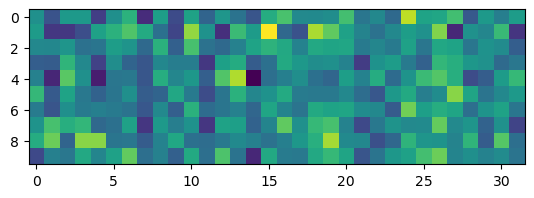

In [89]:
# Initialize the module
key = jax.random.PRNGKey(0)
model = LogitBiasedMultiheadAttention(
    num_heads=num_heads,
    query_size=model_dim,
    key_size=key_dim,
    value_size=value_dim,
    output_size=model_dim,
    dropout_p=0.1,
    inference=False,
    key=key
)

# Call the attention module
result = model(queries, keys, values, biases, key=key)

import matplotlib.pyplot as plt
plt.imshow(result)

In [22]:
model.logit_bias_proj

Linear(
  weight=f32[32,32],
  bias=f32[32],
  in_features=32,
  out_features=32,
  use_bias=True
)